In [1]:
### Trying to reproduce the results using transformers

import copy
from typing import Optional, Any
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import MultiheadAttention
from torch.nn import ModuleList
from torch.nn.init import xavier_uniform_
from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import LayerNorm, BatchNorm1d
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import math

from torch.utils.data import Dataset, DataLoader
from config.config import DEVICE
import time
import os
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
import pickle
def load_config(data_path, fold="train"):
    with open(data_path.format(fold, "config", "pkl"), "rb") as f:
        config = pickle.load(file=f)
    n_units = config["n_units"]
    n_treated = config["n_treated"]
    n_units_total = config["n_units_total"]
    step = config["step"]
    train_step = config["train_step"]
    control_sample = config["control_sample"]
    noise = config["noise"]
    n_basis = config["n_basis"]
    n_cluster = config["n_cluster"]
    return n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster

def load_tensor(data_path, fold="train"):
    print(data_path.format(fold, "x_full", "pth"))
    x_full = torch.load(data_path.format(fold, "x_full", "pth"))
    t_full = torch.load(data_path.format(fold, "t_full", "pth"))
    mask_full = torch.load(data_path.format(fold, "mask_full", "pth"))
    batch_ind_full = torch.load(data_path.format(fold, "batch_ind_full", "pth"))
    y_full = torch.load(data_path.format(fold, "y_full", "pth"))
    y_control = torch.load(data_path.format(fold, "y_control", "pth"))
    y_mask_full = torch.load(data_path.format(fold, "y_mask_full", "pth"))
    m = torch.load(data_path.format(fold, "m", "pth"))
    sd = torch.load(data_path.format(fold, "sd", "pth"))
    treatment_effect = torch.load(data_path.format(fold, "treatment_effect", "pth"))
    return x_full, t_full, mask_full, batch_ind_full, y_full, y_control, y_mask_full, m, sd, treatment_effect


In [18]:
data_path = "./data/sync6d-p10-seed-100"+ "/{}-{}.{}"
n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster = load_config(
    data_path, "train"
)

In [19]:
print(n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster)

1000 200 1200 30 25 1000 0.1 6 2


In [5]:
(x_full,t_full,mask_full,batch_ind_full,y_full,y_control,y_mask_full,m,sd,treatment_effect,) = load_tensor(data_path, "train")

./data/sync6d-p10-seed-100/train-x_full.pth


In [6]:
print(f'x_full: {x_full.shape}') ### Temporal Covariates
print(f't_full: {t_full.shape}') ###  Time -25 to 4
print(f'mask_full: {mask_full.shape}') ### Masking vector
print(f'batch_ind_full: {batch_ind_full.shape}') ### Batch indexes
print(f'y_full: {y_full.shape}')   ### y_i ### need to predict this
print(f'y_control: {y_control.shape}') #### y_i(0)
print(f'treatment_effect: {treatment_effect.shape}')  #### y_i(1)
print(f'y_mask_full: {y_mask_full.shape}') ### To separate control and treatment groups  
print(f'm: {m.shape} {m}') 
print(f'sd: {sd.shape} {sd}')



# print(torch.abs(y_full[:,:1000,:]-y_control).sum())

x_full: torch.Size([25, 1200, 3])
t_full: torch.Size([25, 1200, 3])
mask_full: torch.Size([25, 1200, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([5, 1200, 1])
y_control: torch.Size([5, 1000, 1])
treatment_effect: torch.Size([5, 200, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3]) tensor([0.0118, 0.1373, 1.0291], device='cuda:3')
sd: torch.Size([3]) tensor([0.7947, 3.5020, 7.6243], device='cuda:3')


In [7]:
class LDL_Stim_Dataset(Dataset):
    def __init__(self, data_path, fold,device):
        # Get the data
        (self.x_full,self.t_full,self.mask_full,self.batch_ind_full,
         self.y_full,self.y_control,self.y_mask_full,
         self.m,self.sd,self.treatment_effect,) = load_tensor(data_path, fold)
        print(self.m,self.sd)
        # print(self.x_full.max(),self.x_full.min(),self.x_full.mean())
        self.x_full = torch.moveaxis(self.x_full,1,0)
        # self.x_full = torch.moveaxis(self.x_full,1,-1)
        self.t_full = torch.moveaxis(self.t_full,1,0)
        # self.t_full = torch.moveaxis(self.t_full,1,-1)
        self.mask_full = torch.moveaxis(self.mask_full,1,0)
        # self.mask_full = torch.moveaxis(self.mask_full,1,-1)
        self.y_full = torch.moveaxis(self.y_full,1,0).squeeze()
        self.y_control = torch.moveaxis(self.y_control,1,0)
        self.treatment_effect = torch.moveaxis(self.treatment_effect,1,0)
        # print(self.batch_ind_full)
        self.device = device
        # for i in range (self.x_full.shape[-1]):
        #     self.x_full[:,:,i] = (self.x_full[:,:,i] - self.m[i])/self.sd[i]
        # print(self.x_full.max(),self.x_full.min(),self.x_full.mean())
        print(f'x_full: {self.x_full.shape}') ### Temporal Covariates
        print(f't_full: {self.t_full.shape}') ###  Time -25 to 4
        print(f'mask_full: {self.mask_full.shape}') ### Masking vector
        print(f'batch_ind_full: {self.batch_ind_full.shape}') ### Batch indexes
        print(f'y_full: {self.y_full.shape}')   ### y_i ### need to predict this
        print(f'y_control: {self.y_control.shape}') #### y_i(0)
        print(f'treatment_effect: {self.treatment_effect.shape}')  #### y_i(1)
        print(f'y_mask_full: {self.y_mask_full.shape}') ### if outcome not available during 
        print(f'm: {self.m.shape}') 
        print(f'sd: {self.sd.shape}')

        
    def __len__(self):
        return len(self.x_full)

    def __getitem__(self, idx):
        x = self.x_full[idx].to(self.device)    
        t = self.t_full[idx].to(self.device)    
        m = self.mask_full[idx].to(self.device)    
        y = self.y_full[idx].to(self.device)    
        y_mask = self.y_mask_full[idx].unsqueeze(-1).to(self.device)    
        return x,t,m,y,y_mask

In [8]:
class LDL_Stim_Inference_Dataset(Dataset):
    def __init__(self, data_path, fold,device,group = 'Treated'):
        # Get the data
        (self.x_full,self.t_full,self.mask_full,self.batch_ind_full,
         self.y_full,self.y_control,self.y_mask_full,
         self.m,self.sd,self.treatment_effect,) = load_tensor(data_path, fold)
        
        
        self.x_full = torch.moveaxis(self.x_full,1,0)
        self.t_full = torch.moveaxis(self.t_full,1,0)
        self.mask_full = torch.moveaxis(self.mask_full,1,0)
        self.y_full = torch.moveaxis(self.y_full,1,0).squeeze()
        self.y_control = torch.moveaxis(self.y_control,1,0)
        self.treatment_effect = torch.moveaxis(self.treatment_effect,1,0)
        
        self.device = device
        
        print(f"Loading {group} Group")
        if group == 'Treated':
            self.x_full = self.x_full[self.y_mask_full==0]
            self.t_full = self.t_full[self.y_mask_full==0]
            self.mask_full = self.mask_full[self.y_mask_full==0]
            self.y_full = self.y_full[self.y_mask_full==0]
            self.batch_ind_full = self.batch_ind_full[self.y_mask_full==0]
            # self.ITE = self.treatment_effect
        elif group == 'Control':
            self.x_full = self.x_full[self.y_mask_full==1]
            self.t_full = self.t_full[self.y_mask_full==1]
            self.mask_full = self.mask_full[self.y_mask_full==1]
            self.y_full = self.y_full[self.y_mask_full==1]
            self.batch_ind_full = self.batch_ind_full[self.y_mask_full==1]
            
            
        
        
        
        print(f'x_full: {self.x_full.shape}') ### Temporal Covariates
        print(f't_full: {self.t_full.shape}') ###  Time -25 to 4
        print(f'mask_full: {self.mask_full.shape}') ### Masking vector
        print(f'batch_ind_full: {self.batch_ind_full.shape}') ### Batch indexes
        print(f'y_full: {self.y_full.shape}')   ### y_i ### need to predict this
        print(f'y_control: {self.y_control.shape}') #### y_i(0)
        print(f'treatment_effect: {self.treatment_effect.shape}')  #### y_i(1)
        print(f'y_mask_full: {self.y_mask_full.shape}') ### if outcome not available during 
        print(f'm: {self.m.shape}') 
        print(f'sd: {self.sd.shape}')

        
    def __len__(self):
        return len(self.x_full)

    def __getitem__(self, idx):
        x = self.x_full[idx].to(self.device)    
        t = self.t_full[idx].to(self.device)    
        m = self.mask_full[idx].to(self.device)    
        y = self.y_full[idx].to(self.device)    
        y_mask = self.y_mask_full[idx].unsqueeze(-1).to(self.device)  
        batch_ind = self.batch_ind_full[idx].to(self.device)  
        return x,t,m,y,y_mask,batch_ind

In [9]:
data_path = "./data/sync6d-p10-seed-100"+ "/{}-{}.{}"
train_dataset = LDL_Stim_Dataset(data_path, fold = 'train',device = DEVICE)
val_treated_dataset = LDL_Stim_Inference_Dataset(data_path, fold = 'val',device = DEVICE,group = 'Treated')
val_control_dataset = LDL_Stim_Inference_Dataset(data_path, fold = 'val',device = DEVICE,group = 'Control')

./data/sync6d-p10-seed-100/train-x_full.pth
tensor([0.0118, 0.1373, 1.0291], device='cuda:3') tensor([0.7947, 3.5020, 7.6243], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
./data/sync6d-p10-seed-100/val-x_full.pth
Loading Treated Group
x_full: torch.Size([200, 25, 3])
t_full: torch.Size([200, 25, 3])
mask_full: torch.Size([200, 25, 3])
batch_ind_full: torch.Size([200])
y_full: torch.Size([200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
./data/sync6d-p10-seed-100/val-x_full.pth
Loading Control Group
x_full: torch.Size([1000, 25, 3])
t_full: torch.Size([1000, 25, 3])
mask_full: torch.Size([1000

In [10]:
train_data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_treated_data_loader = DataLoader(val_treated_dataset, batch_size = 200, shuffle = False)
val_control_data_loader = DataLoader(val_control_dataset, batch_size = 1000, shuffle = False)

In [11]:
x,t,m,y,y_mask   = next(iter(train_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape )

torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 5]) torch.Size([32, 1])


## Model

In [102]:
class LSTM_Encoder(nn.Module): 
    def __init__(self, in_dim,hidden_dim):
        super(LSTM_Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, bidirectional=True,batch_first=True)
        self.atten = nn.Parameter(torch.ones(1,1,hidden_dim*2))
    def forward(self, x):
        x,_ = self.lstm (x)
        atten = repeat(self.atten, '() s e -> b e s', b=x.shape[0])
        # print(x.shape,atten.shape)
        atten_weight = torch.softmax(torch.matmul(x, atten) / math.sqrt(self.hidden_dim), dim=1)
        # print(atten_weight.shape,x.shape)
        x = torch.sum(x * atten_weight, dim=1)
        return x
    

class LSTM_Decoder(nn.Module): 
    def __init__(self,hidden_dim,out_dim,time_points):
        super(LSTM_Decoder, self).__init__()
        
        self.time_points = time_points
        self.lstm = nn.LSTM(hidden_dim, hidden_dim,batch_first=True)
        self.final = Linear(hidden_dim, out_dim)
    def forward(self, c):
        out,h = self.lstm(c)
        
        out_main = self.final(out).unsqueeze(1)
        # print(out_main.shape)
        for i in range(self.time_points-1):
            out,h = self.lstm(c,h)
            out_main = torch.cat((out_main,self.final(out).unsqueeze(1)),dim=1)
            
        
        
        return out_main

class linear_cls(nn.Module):
    def __init__(self,hidden_dim,y_times = 5):
        super(linear_cls, self).__init__()
        
        self.Q = nn.Linear(hidden_dim, y_times)
    def forward(self, x):
        # print(x.shape)
        # x = torch.flatten(x, start_dim=1, end_dim=- 1) 
        x = self.Q(x)
        return x
        

In [103]:
encoder = LSTM_Encoder(in_dim = 3,hidden_dim = 20).to(DEVICE)
decoder = LSTM_Decoder(hidden_dim = 40,out_dim = 3,time_points = 25).to(DEVICE)
Q = linear_cls(hidden_dim = 40).to(DEVICE)

## Testing
x,t,m,y,y_mask   = next(iter(train_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape )


c_hat = encoder(x)
print(c_hat.shape)
x_hat = decoder(c_hat)
y_hat = Q(c_hat)

print(c_hat.shape,x_hat.shape,y_hat.shape)

torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 5]) torch.Size([32, 1])
torch.Size([32, 40])
torch.Size([32, 40]) torch.Size([32, 25, 3]) torch.Size([32, 5])


## Representation learning training

In [104]:
def get_representation(encoder,data_loader):
    
    for batch_idx, (x,t,m,y,y_mask,batch_ind) in enumerate(data_loader): 
        c_hat = encoder(x)#[:,0,:]
        if batch_idx ==0:
            c = c_hat
        else:
            c = torch.cat((c,c_hat),dim = 0)
    c = torch.flatten(c,start_dim=1)
    return c
            
    

In [105]:
#Training parameters
criterion = nn.L1Loss()
lr_u  = 0.001   
beta_1 = 0.9
beta_2 = 0.999
n_epochs = 100
save_model_freq = 100

In [106]:
#Initiate optimizers
opt =  torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters())+ list(Q.parameters()), lr=lr_u, betas=(beta_1, beta_2))

In [107]:
def recon_loss(x_hat,x,m):
    criterion = nn.MSELoss()
    return criterion(x_hat*m,x*m)

def sup_loss(y_hat,y,y_mask):
    criterion = nn.MSELoss()
    return criterion(y_hat*y_mask,y*y_mask)

def matching_loss(c_hat,c):
    criterion = nn.MSELoss()
    return criterion(c_hat,c)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0


In [171]:
def learn_B_val(c_target,c_non_target,val_dataset,num_iterations=1000):
    B = torch.zeros(len(c_target),len(c_non_target)).to(DEVICE).requires_grad_(True)#nn.Parameter(torch.zeros(len(c_target),len(c_non_target),1,1)).to(DEVICE)
    B_mask = (1-torch.diag(torch.ones(len(c_target))).to(DEVICE)).requires_grad_(True)
    # B_mask = torch.diag(torch.ones(len(c_target))*(-1e12)).to(DEVICE).requires_grad_(True)

    print(B.shape,c_target.shape,c_non_target.shape)
    
    # plt.figure(figsize=(30,10))
    # im = plt.imshow(B.squeeze().detach().cpu().numpy(),cmap = 'jet')
    # plt.colorbar(shrink = 0.5)
    # plt.show()
    
    opt =  torch.optim.Adam([B], lr=0.0001, betas=(0.9, 0.999))
    matching_losses = []
    # val_data_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
    for i in range(num_iterations):
        
        # target_ind = np.random.choice(len(c_target),32,replace=False)
        # for batch_idx, (_,_,_,_,_,target_ind ) in enumerate(val_data_loader):  
        opt.zero_grad()
        # c_target_sample = c_target#[target_ind]

    # print(B[target_ind]*B_mask[target_ind][0])
        # c_estimate = torch.matmul(B[target_ind]*B_mask[target_ind],c_non_target)#F.gumbel_softmax(B[target_ind[ind]]*c_non_target, tau=1.2, hard=False,dim=0)
        c_estimate = torch.matmul(B*B_mask,c_non_target)#F.gumbel_softmax(B[target_ind[ind]]*c_non_target, tau=1.2, hard=False,dim=0)

        loss = matching_loss(c_estimate,c_target)#/len(target_ind) 
        loss.backward()
        opt.step()
        matching_losses.append(loss.data.item())
        
    # print(matching_losses)
    # plt.figure(figsize=(30,10))
    # plt.imshow(B.squeeze().detach().cpu().numpy(),cmap = 'jet')
    # plt.colorbar(shrink = 0.5)
    # plt.show()
    
    fig = plt.figure()
    plt.plot(matching_losses)
    if is_wandb:
        wandb.log({"val_Lm" : wandb.Image(fig)})
    
    # print(matching_losses[-1])
    
#     fig, axs = plt.subplots(1, 2, figsize = (20,10))
#     im = axs[0].plot(c_target_sample[0].squeeze().detach().cpu().numpy())#,cmap = 'jet')
#     axs[0].set_title(f"C Target")
#     # plt.colorbar(im, ax=axs[0],shrink = 0.7)
    
#     im = axs[1].plot(c_estimate[0].squeeze().detach().cpu().numpy())#,cmap = 'jet')
#     axs[1].set_title(f"C Est, Error:{torch.abs(c_target_sample[12].squeeze() - c_estimate[12].squeeze()).sum()}")
#     # plt.colorbar(im, ax=axs[1],shrink = 0.7)
    
    return B


def estimate_y(B,y_non_target):
    B_mask = (1-torch.diag(torch.ones(B.shape[0])).to(DEVICE))
    with torch.no_grad():
        # for i in range(B.shape[0]):
        y_hat = torch.matmul(B.squeeze()*B_mask,y_non_target)
    return y_hat
    

In [152]:
is_wandb = True
if is_wandb:
    import wandb
    wandb.init(project="SyncTwin", entity="jathurshan_0330")
    wandb.run.name = "LSTM_validation_with_matching_loss"
    wandb.run.save()
    
    exp_path = f"/home/jupyter-jathurshan/SyncTwin_Results/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)


batch_loss,▁▁▁▄▁▁▁▁▃▂▁█▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch_saved_Best_Model,▁▃▆█▁▂▅▁▁▁
train_epoch_loss,▄▅▅▇▅▄█▄█▇█▄▅▃▃▅▄▄▂▄▃▄▂▃▄▃▃▁▃▄▁▂▂▂▄▆▂▄█▄
training time/Iter,▆▄▁▃▄▅▃▂▂▃▅▅▅▆▅▄▂▃▄▂▃▃▄▇▄▆▄▄▄▃▃▇▂▃▄█▆▃▅▄
val_epoch_loss,▁▁▁▁▁▁▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█████████████
batch_loss,0.40159
epoch_saved_Best_Model,1
train_epoch_loss,0.04035
training time/Iter,0.04209
val_epoch_loss,2.0641


In [172]:
def train(encoder,decoder,Q,opt,data_loader,is_wandb,verbose_freq = 500):
    encoder.train()
    decoder.train()
    Q.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_losses = AverageMeter()
    end = time.time()
    
    for batch_idx, (x,t,m,y,y_mask ) in enumerate(data_loader): 
        data_time.update(time.time() - end)
        
        opt.zero_grad()
        c_hat = encoder(x)
        x_hat = decoder(c_hat)
        y_hat = Q(c_hat)
        
        loss = recon_loss(x_hat,x,m) + sup_loss(y_hat,y,y_mask)
        
        loss.backward()
        opt.step()
        
        train_losses.update(loss.data.item())
        batch_time.update(time.time() - end)
        end = time.time()
        
        if (batch_idx+1) % verbose_freq == 0:
            msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                  'Speed {speed:.1f} samples/s\t' \
                  'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t' \
                  'Loss {train_loss.val:.5f} ({train_loss.avg:.5f})\t'.format(
                      epoch_idx+1, batch_idx,len(data_loader), n_epochs , batch_time=batch_time,
                      speed=x.size(0)/batch_time.val,
                      data_time=data_time, train_loss=train_losses)
            print(msg)
        
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            wandb.log({"training time/Iter": batch_time.sum/len(data_loader)})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    print(f"Training Epoch Loss: {train_losses.avg}")#,Training Time/Epoch: {batch_time.sum},Training Time/Iter: {batch_time.sum/len(data_loader)}")
    
    
        
        
        
    

In [173]:
def validate(encoder,decoder,Q,data_loader,val_dataset,is_wandb):
    encoder.eval()
    decoder.eval()
    Q.eval()
    
    # val_losses = AverageMeter()
    
    
    with torch.no_grad():
        c_control  = get_representation(encoder,data_loader).detach().to(DEVICE).requires_grad_(False)
    B_control = learn_B_val(c_control,c_control,val_dataset,num_iterations =10)
        

    x_control,t_control,m_control,y_control,y_mask_control,batch_ind_control   = next(iter(data_loader))
    y_hat = estimate_y(B_control,y_control)
    loss = matching_loss(y_hat,y_control)
        
        # val_losses.update(loss.data.item())
        
    fig = plt.figure()
    plt.imshow(B_control.squeeze().detach().cpu().numpy(),cmap='jet')
    plt.colorbar()
    if is_wandb:
        wandb.log({"B_val" : wandb.Image(fig)})

    if is_wandb:
        wandb.log({"val_epoch_loss": loss.data.item()})

    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    print(f"Val Epoch Loss: {loss.data.item()}")
    return loss.data.item()
        

Training Epoch : [1/100]===============================================================================
Training Epoch Loss: 0.04127740796263281
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([1000, 40])
Val Epoch Loss: 1.987538456916809
Saving Best Model =======================================>
Training Epoch : [2/100]===============================================================================
Training Epoch Loss: 0.04973666570884617
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([1000, 40])
Val Epoch Loss: 1.9901338815689087
Training Epoch : [3/100]===============================================================================
Training Epoch Loss: 0.03191296873908294
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([1000, 40])
Val Epoch Loss: 1.989911675453186
Training Epoch : [4/100]===============================================================================
Training Epoch Loss: 0.03300597229482312
torch.Size([1000, 1000]) torch.Size([1000, 40

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Val Epoch Loss: 1.9904130697250366
Training Epoch : [12/100]===============================================================================
Training Epoch Loss: 0.03266945089164533
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([1000, 40])
Val Epoch Loss: 1.9904752969741821
Training Epoch : [13/100]===============================================================================
Training Epoch Loss: 0.03079522886362515
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([1000, 40])
Val Epoch Loss: 1.9903393983840942
Training Epoch : [14/100]===============================================================================
Training Epoch Loss: 0.029312096095006717
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([1000, 40])
Val Epoch Loss: 1.9923760890960693
Training Epoch : [15/100]===============================================================================
Training Epoch Loss: 0.03144048850395178
torch.Size([1000, 1000]) torch.Size([1000, 40]) torch.Size([10

AttributeError: eventson

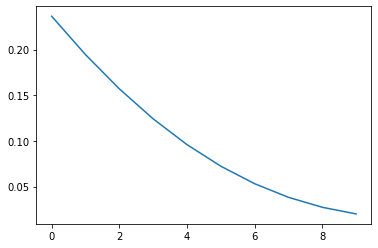

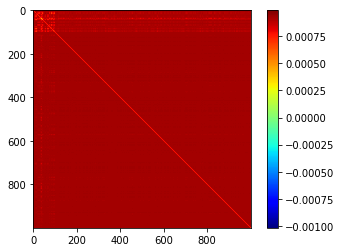

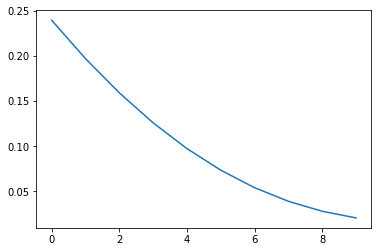

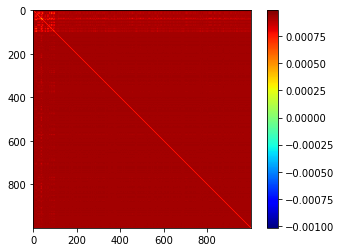

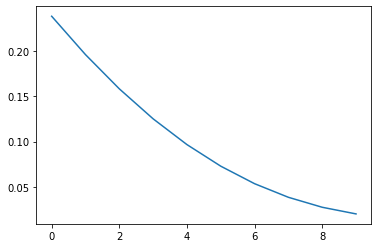

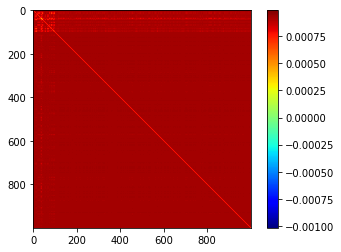

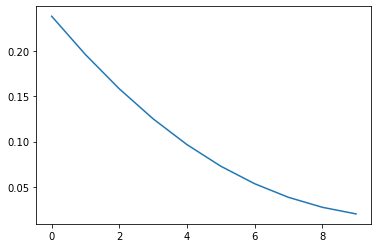

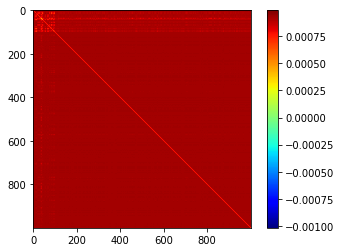

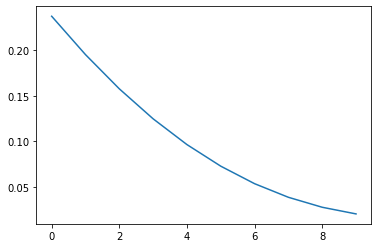

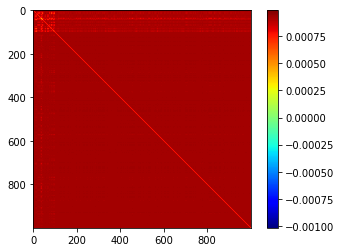

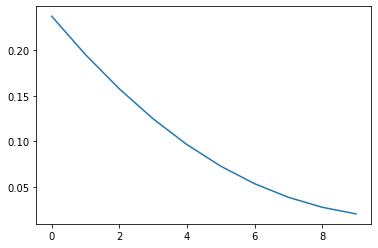

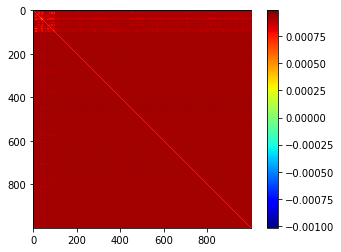

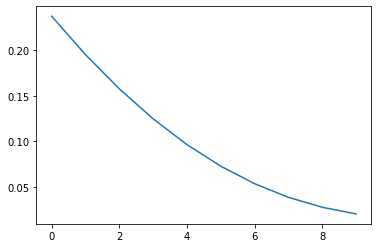

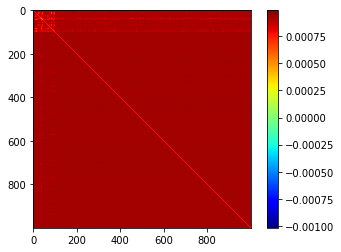

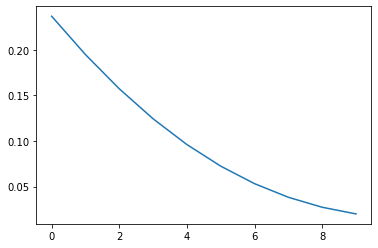

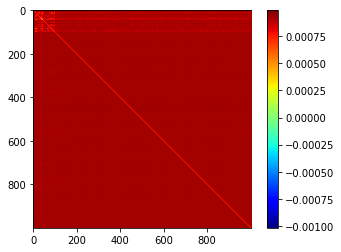

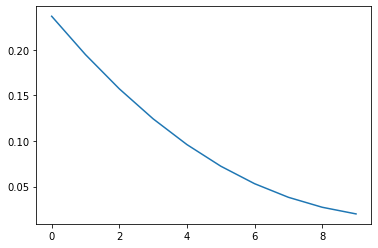

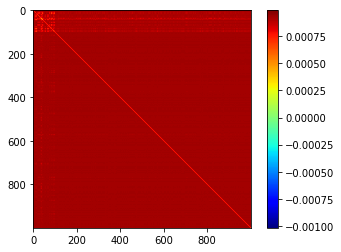

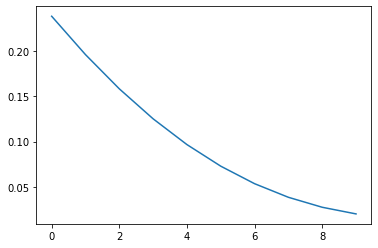

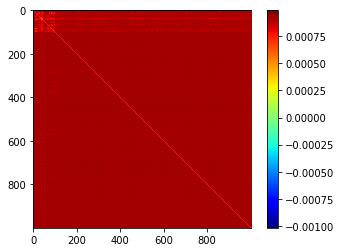

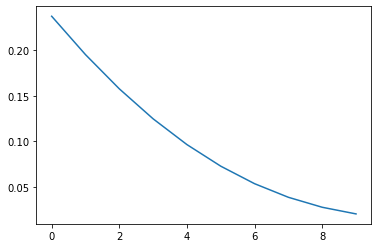

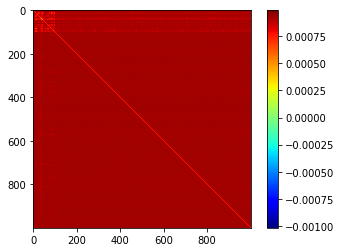

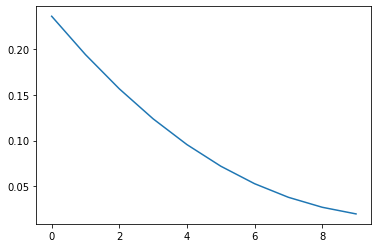

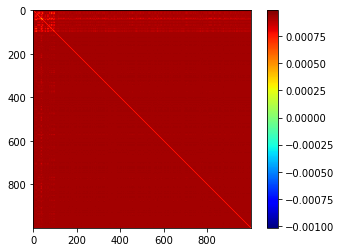

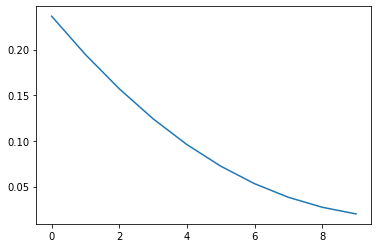

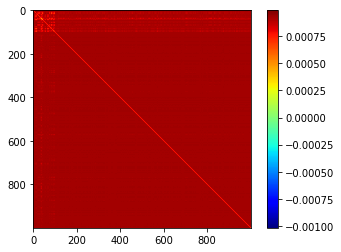

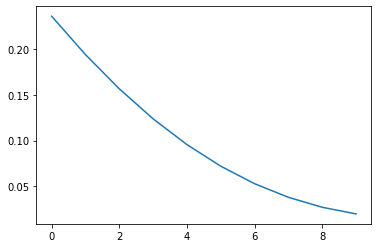

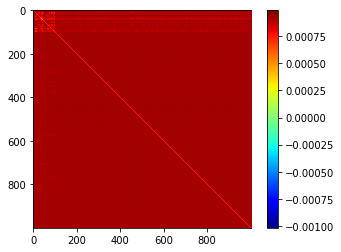

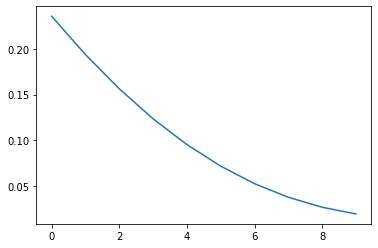

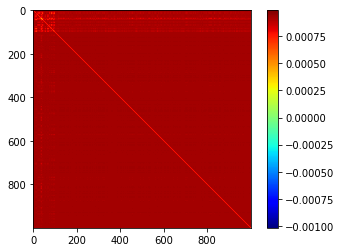

<Figure size 432x288 with 0 Axes>

In [174]:
val_best_loss = 10000000

for epoch_idx in range(n_epochs):
    print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    train(encoder,decoder,Q,opt,train_data_loader,is_wandb,verbose_freq = 500)    
    val_losses = validate(encoder,decoder,Q,val_control_data_loader,val_control_dataset,is_wandb) 
    # break
    if (val_losses < val_best_loss) and is_wandb: 
        val_best_loss = val_losses
        print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder.pth.tar')
        torch.save(Q, f'{exp_path}/Q.pth.tar')
        wandb.log({"epoch_saved_Best_Model": epoch_idx+1})


# Inference for predicting conterfactual of y(0)

In [147]:
class LDL_Stim_Inference_Dataset(Dataset):
    def __init__(self, data_path, fold,device,group = 'Treated'):
        # Get the data
        (self.x_full,self.t_full,self.mask_full,self.batch_ind_full,
         self.y_full,self.y_control,self.y_mask_full,
         self.m,self.sd,self.treatment_effect,) = load_tensor(data_path, fold)
        
        
        self.x_full = torch.moveaxis(self.x_full,1,0)
        self.t_full = torch.moveaxis(self.t_full,1,0)
        self.mask_full = torch.moveaxis(self.mask_full,1,0)
        self.y_full = torch.moveaxis(self.y_full,1,0).squeeze()
        self.y_control = torch.moveaxis(self.y_control,1,0)
        self.treatment_effect = torch.moveaxis(self.treatment_effect,1,0)
        
        self.device = device
        
        print(f"Loading {group} Group")
        if group == 'Treated':
            self.x_full = self.x_full[self.y_mask_full==0]
            self.t_full = self.t_full[self.y_mask_full==0]
            self.mask_full = self.mask_full[self.y_mask_full==0]
            self.y_full = self.y_full[self.y_mask_full==0]
            self.batch_ind_full = self.batch_ind_full[self.y_mask_full==0]
            # self.ITE = self.treatment_effect
        elif group == 'Control':
            self.x_full = self.x_full[self.y_mask_full==1]
            self.t_full = self.t_full[self.y_mask_full==1]
            self.mask_full = self.mask_full[self.y_mask_full==1]
            self.y_full = self.y_full[self.y_mask_full==1]
            self.batch_ind_full = self.batch_ind_full[self.y_mask_full==1]
            
            
        
        
        
        print(f'x_full: {self.x_full.shape}') ### Temporal Covariates
        print(f't_full: {self.t_full.shape}') ###  Time -25 to 4
        print(f'mask_full: {self.mask_full.shape}') ### Masking vector
        print(f'batch_ind_full: {self.batch_ind_full.shape}') ### Batch indexes
        print(f'y_full: {self.y_full.shape}')   ### y_i ### need to predict this
        print(f'y_control: {self.y_control.shape}') #### y_i(0)
        print(f'treatment_effect: {self.treatment_effect.shape}')  #### y_i(1)
        print(f'y_mask_full: {self.y_mask_full.shape}') ### if outcome not available during 
        print(f'm: {self.m.shape}') 
        print(f'sd: {self.sd.shape}')

        
    def __len__(self):
        return len(self.x_full)

    def __getitem__(self, idx):
        x = self.x_full[idx].to(self.device)    
        t = self.t_full[idx].to(self.device)    
        m = self.mask_full[idx].to(self.device)    
        y = self.y_full[idx].to(self.device)    
        y_mask = self.y_mask_full[idx].unsqueeze(-1).to(self.device)  
        batch_ind = self.batch_ind_full[idx].to(self.device)  
        return x,t,m,y,y_mask,batch_ind

In [148]:
test_treated_dataset = LDL_Stim_Inference_Dataset(data_path, fold = 'test',device = DEVICE,group = 'Treated') 
test_control_dataset = LDL_Stim_Inference_Dataset(data_path, fold = 'test',device = DEVICE,group = 'Control') 

./data/sync6d-p10-seed-100/test-x_full.pth
Loading Treated Group
x_full: torch.Size([200, 25, 3])
t_full: torch.Size([200, 25, 3])
mask_full: torch.Size([200, 25, 3])
batch_ind_full: torch.Size([200])
y_full: torch.Size([200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
./data/sync6d-p10-seed-100/test-x_full.pth
Loading Control Group
x_full: torch.Size([1000, 25, 3])
t_full: torch.Size([1000, 25, 3])
mask_full: torch.Size([1000, 25, 3])
batch_ind_full: torch.Size([1000])
y_full: torch.Size([1000, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])


In [149]:
treatment_data_loader = DataLoader(test_treated_dataset, batch_size = 200, shuffle = False)
control_data_loader = DataLoader(test_control_dataset, batch_size = 1000, shuffle = False)

In [150]:
x,t,m,y,y_mask,batch_ind   = next(iter(control_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape,batch_ind.shape,len(control_data_loader),len(treatment_data_loader) )

torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 5]) torch.Size([1000, 1]) torch.Size([1000]) 1 1


In [151]:
# batch_ind[1]#.detach().cpu().numpy()
# x[batch_ind[1]]

In [157]:
def get_representation(encoder,data_loader):
    
    for batch_idx, (x,t,m,y,y_mask,batch_ind) in enumerate(data_loader): 
        c_hat = encoder(x)#[:,0,:]
        if batch_idx ==0:
            c = c_hat
        else:
            c = torch.cat((c,c_hat),dim = 0)
    c = torch.flatten(c,start_dim=1)
    return c
            
    

In [158]:
#Load encoder
enc_path = '/home/jupyter-jathurshan/SyncTwin_Results/Initial_With_Transformers_v1_retraining/encoder.pth.tar'
encoder = torch.load(enc_path).to(DEVICE)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

166272


In [161]:
c_treat  = get_representation(encoder,treatment_data_loader).detach().to(DEVICE).requires_grad_(False)
c_control  = get_representation(encoder,control_data_loader).detach().to(DEVICE).requires_grad_(False)

print(c_treat.shape,c_control.shape)

torch.Size([200, 1600]) torch.Size([1000, 1600])


In [162]:
def matching_loss(c_hat,c):
    criterion = nn.MSELoss()
    return criterion(c_hat,c)


In [163]:
def learn_B_for_one_sample(c_target,c_non_target,num_iterations=1000):
    B = torch.zeros(len(c_non_target),1).to(DEVICE).requires_grad_(True)#nn.Parameter(torch.zeros(len(c_target),len(c_non_target),1,1)).to(DEVICE)
    print(B.shape,c_target.shape,c_non_target.shape)
    
    plt.figure(figsize=(30,10))
    plt.plot(B.squeeze().detach().cpu().numpy())
    # plt.colorbar(shrink = 0.5)
    # plt.show()
    
    opt =  torch.optim.Adam([B], lr=0.0001, betas=(0.9, 0.999))
    matching_losses = []
    for i in range(num_iterations):
        opt.zero_grad()
        # print((B*c_non_target).shape)
        c_est = B*c_non_target#F.gumbel_softmax(B*c_non_target, tau=1.2, hard=False,dim=0)#B*c_non_target#, tau=1.2, hard=False)
        c_est = torch.sum(c_est,axis=0).unsqueeze(0)
        
        loss = matching_loss(c_est,c_target.unsqueeze(0))#/len(target_ind) 
        loss.backward()
        opt.step()
        matching_losses.append(loss.data.item())
        
    # print(matching_losses)
    
    
    # plt.figure(figsize=(30,10))
    plt.plot(B.squeeze().detach().cpu().numpy())
    # plt.colorbar(shrink = 0.5)
    # plt.show()
    
    
    plt.figure()
    plt.plot(matching_losses)
    plt.show()
    
    # print(matching_losses[-1])
    
    
    
    
    fig, axs = plt.subplots(1, 2, figsize = (20,10))
    im = axs[0].plot(c_target.squeeze().detach().cpu().numpy())#,cmap = 'jet')
    axs[0].set_title(f"C Target")
    # plt.colorbar(im, ax=axs[0],shrink = 0.7)
    
    im = axs[1].plot(c_est.squeeze().detach().cpu().numpy())#,cmap = 'jet')
    axs[1].set_title(f"C Est, Error: {torch.abs((c_target.squeeze()-c_est.squeeze())).sum()}")
    # plt.colorbar(im, ax=axs[1],shrink = 0.7)

    return B
    
        
def estimate_y_one_sample(B,y_non_target):
    with torch.no_grad():
        print(B.shape,y_non_target.shape)
        y_hat = torch.matmul(B.T,y_non_target)
    return y_hat
    
    
                    

In [164]:
(x_full,t_full,mask_full,batch_ind_full,y_full,y_control,y_mask_full,m,sd,treatment_effect,) = load_tensor(data_path, "test")

./data/sync6d-p10-seed-100/test-x_full.pth


torch.Size([1000, 1]) torch.Size([1600]) torch.Size([1000, 1600])


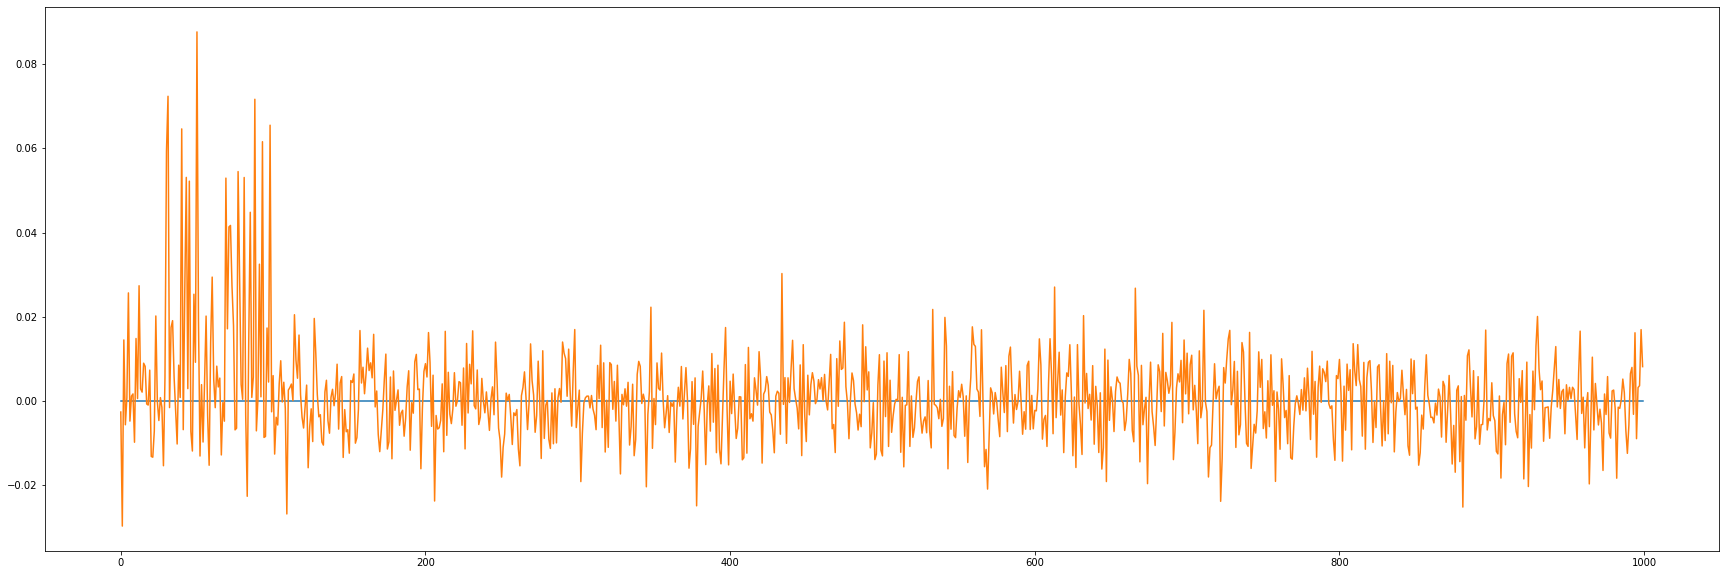

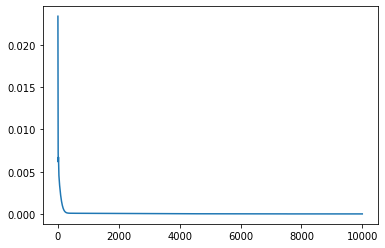

torch.Size([1000, 1]) torch.Size([1000, 5])
torch.Size([1000, 1]) torch.Size([1000, 5])
torch.Size([1, 5]) torch.Size([5])


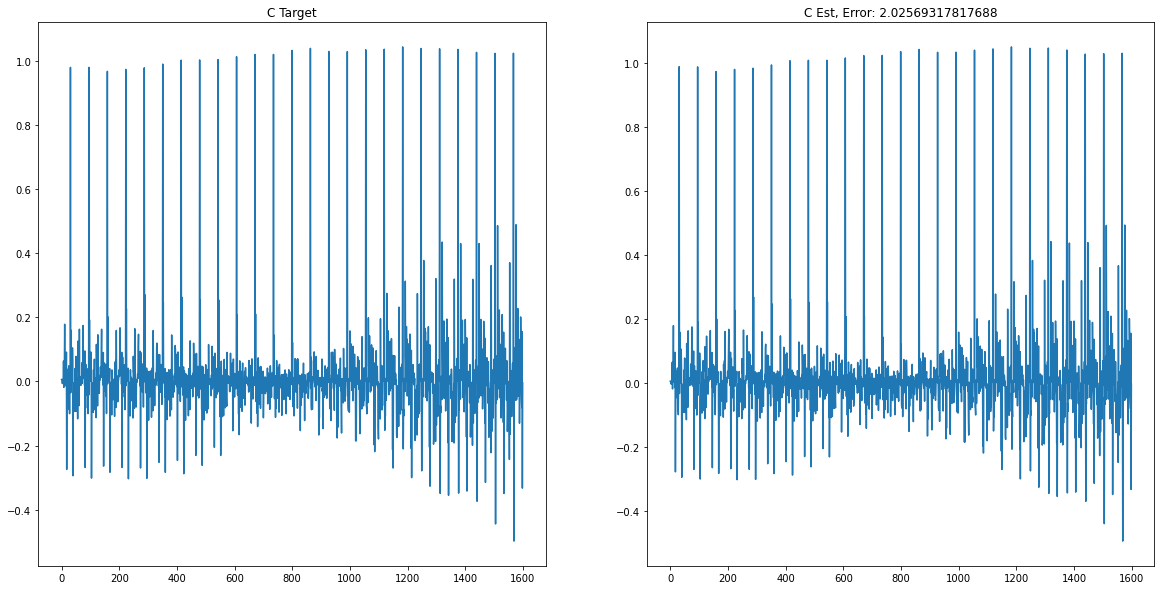

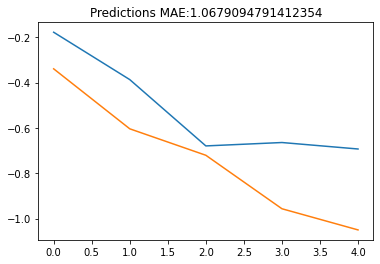

In [165]:
i = 12#14:0#12:2
B_treat = learn_B_for_one_sample(c_treat[i],c_control,num_iterations =10000)

x_control,t_control,m_control,y_control,y_mask_control,batch_ind_control   = next(iter(control_data_loader))
x_treat,t_treat,m_treat,y_treat,y_mask_treat,batch_ind_treat   = next(iter(treatment_data_loader))

print(B_treat.shape,y_control.shape)
y_hat = estimate_y_one_sample(B_treat,y_control)



plt.figure()
plt.plot(y_treat[i].squeeze().detach().cpu().numpy())
plt.plot(y_hat.squeeze().detach().cpu().numpy())
plt.title(f"Predictions MAE:{torch.abs(y_treat[i].squeeze()-y_hat.squeeze()).sum()}")

print(y_hat.shape,y_treat[i].shape)

In [172]:
def learn_B_val(c_target,c_non_target,num_iterations=1000):
    B = torch.zeros(len(c_target),len(c_non_target)).to(DEVICE).requires_grad_(True)#nn.Parameter(torch.zeros(len(c_target),len(c_non_target),1,1)).to(DEVICE)
    B_mask = 1-torch.diag(torch.ones(len(c_target)))
    print(B.shape,c_target.shape,c_non_target.shape)
    
    plt.figure(figsize=(30,10))
    im = plt.imshow(B.squeeze().detach().cpu().numpy(),cmap = 'jet')
    plt.colorbar(shrink = 0.5)
    plt.show()
    
    opt =  torch.optim.Adam([B], lr=0.0001, betas=(0.9, 0.999))
    matching_losses = []
    for i in range(num_iterations):
        opt.zero_grad()
        target_ind = np.random.choice(len(c_target),32,replace=False)
        c_target_sample = c_target[target_ind]
        # for ind in range(len(target_ind)):
        # print(B[target_ind].shape,c_non_target.shape)
        c_estimate = torch.matmul(B[target_ind]*B_mask[target_ind],c_non_target)#F.gumbel_softmax(B[target_ind[ind]]*c_non_target, tau=1.2, hard=False,dim=0)
            
            # if ind ==0:
            #     c_estimate = torch.sum(c_est,axis=0).unsqueeze(0)
            # else:
            #     c_estimate = torch.cat((c_estimate,torch.sum(c_est,axis=0).unsqueeze(0)),dim=0)
    
        loss = matching_loss(c_estimate,c_target_sample)#/len(target_ind) 
        loss.backward()
        opt.step()
        matching_losses.append(loss.data.item())
        
    # print(matching_losses)
    plt.figure(figsize=(30,10))
    plt.imshow(B.squeeze().detach().cpu().numpy(),cmap = 'jet')
    plt.colorbar(shrink = 0.5)
    plt.show()
    
    plt.figure()
    plt.plot(matching_losses)
    plt.show()
    
    # print(matching_losses[-1])
    
    fig, axs = plt.subplots(1, 2, figsize = (20,10))
    im = axs[0].imshow(c_target_sample.squeeze().detach().cpu().numpy(),cmap = 'jet')
    axs[0].set_title(f"C Target")
    plt.colorbar(im, ax=axs[0],shrink = 0.7)
    
    im = axs[1].imshow(c_estimate.squeeze().detach().cpu().numpy(),cmap = 'jet')
    axs[1].set_title(f"C Est, Error:{torch.abs(c_target_sample[12].squeeze() - c_estimate[12].squeeze()).sum()}")
    plt.colorbar(im, ax=axs[1],shrink = 0.7)
    
    return B


def estimate_y(B,y_non_target):
    with torch.no_grad():
        # for i in range(B.shape[0]):
        y_hat = torch.matmul(B.squeeze(),y_non_target)
    return y_hat
    

torch.Size([200, 1000]) torch.Size([200, 1600]) torch.Size([1000, 1600])


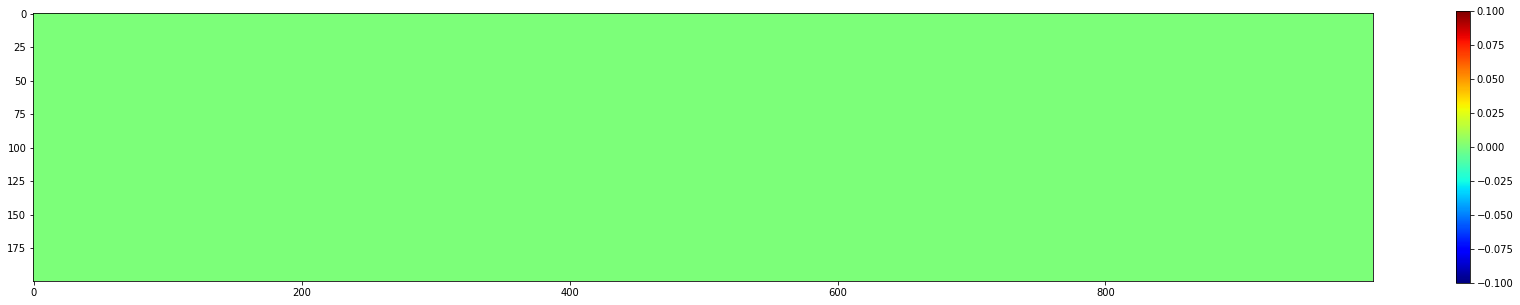

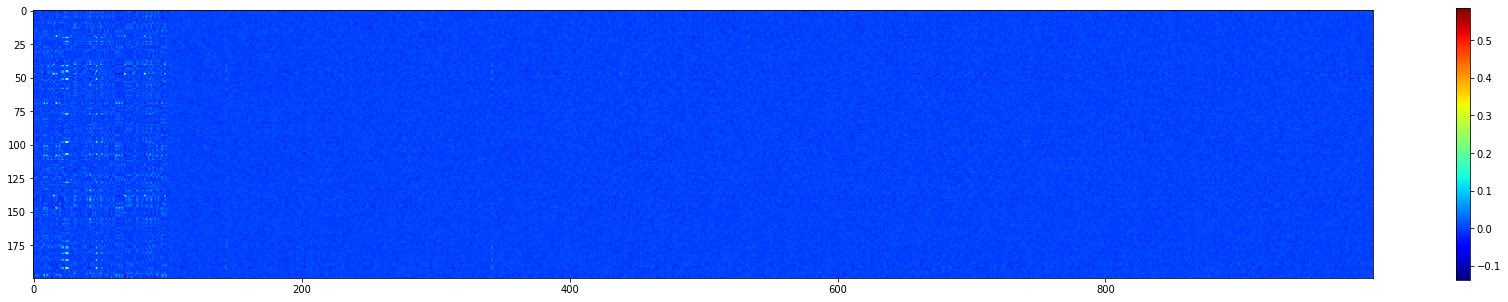

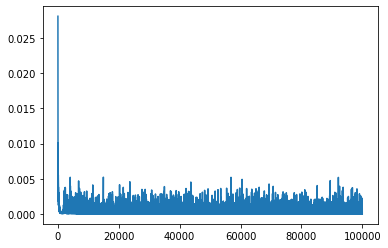

7.366375939454883e-06
torch.Size([200, 1000]) torch.Size([1000, 5])
torch.Size([200, 5]) torch.Size([200, 5])


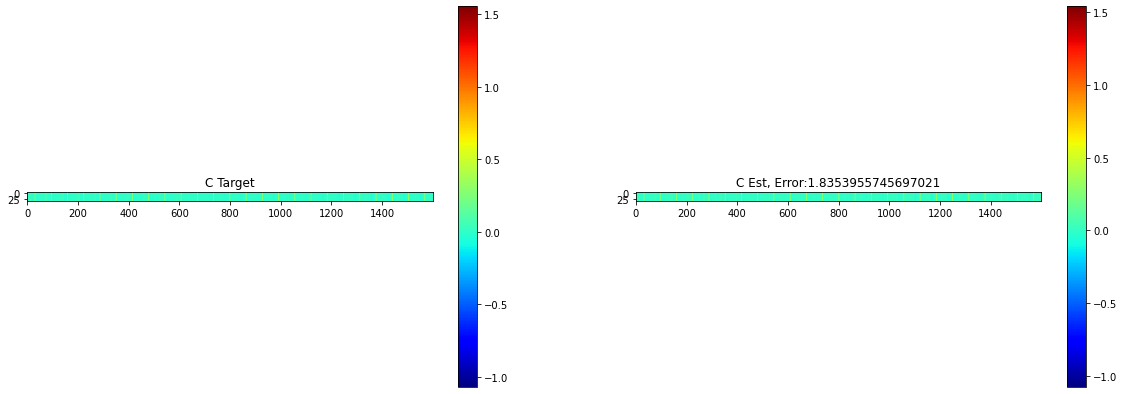

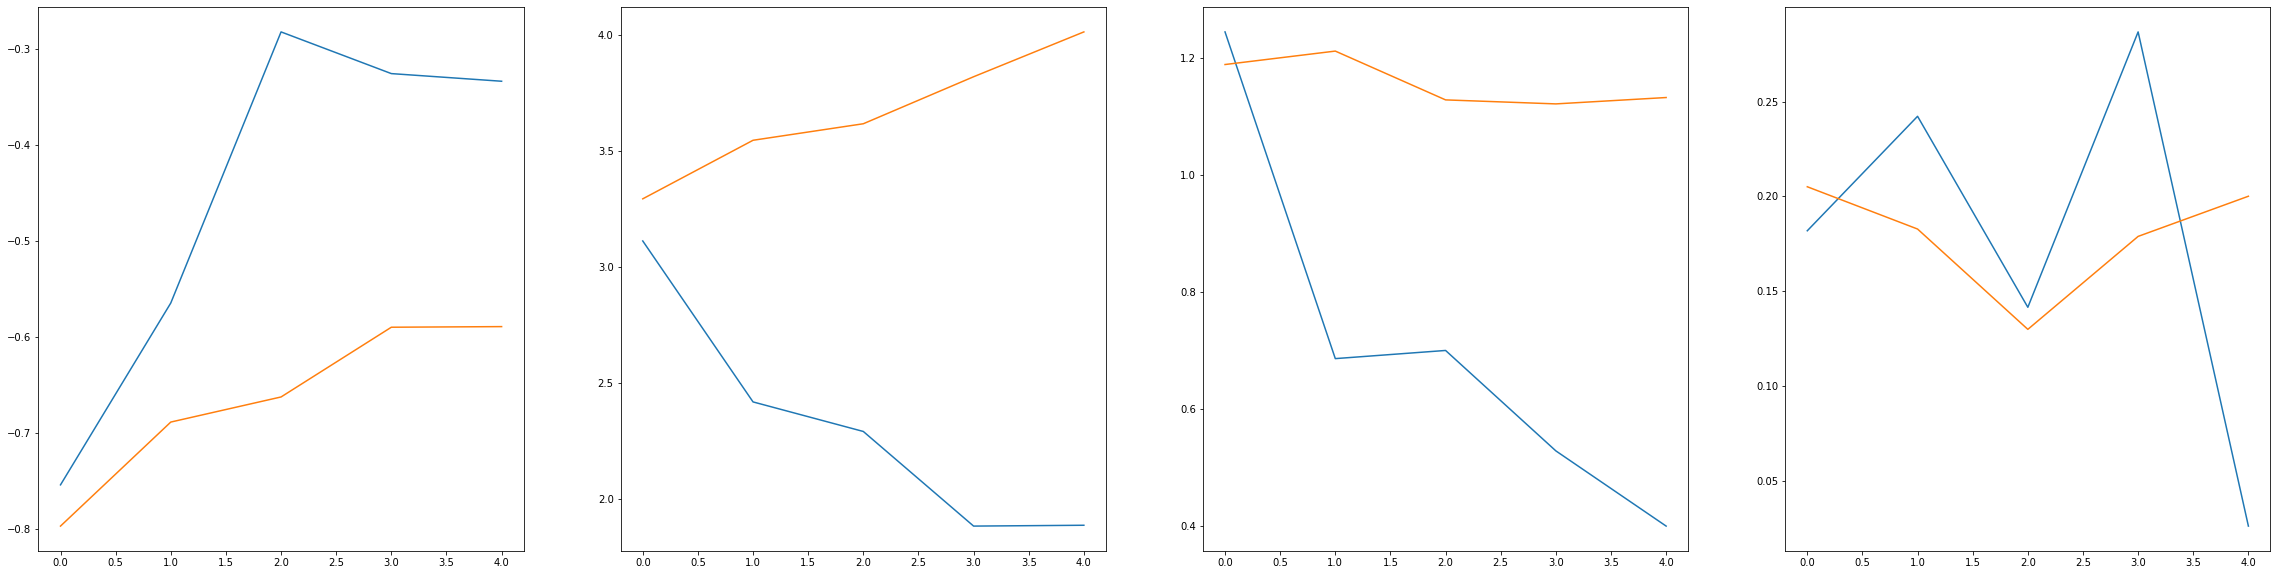

In [173]:
B_treat = learn_B(c_treat,c_control,num_iterations =100000)

x_control,t_control,m_control,y_control,y_mask_control,batch_ind_control   = next(iter(control_data_loader))
x_treat,t_treat,m_treat,y_treat,y_mask_treat,batch_ind_treat   = next(iter(treatment_data_loader))

print(B_treat.shape,y_control.shape)
y_hat_main = estimate_y(B_treat,y_control)

print(y_treat.shape,y_hat_main.shape)

random_list = [3,5,1,6]
fig, axs = plt.subplots(1, 4, figsize = (40,10))
c = 0
for i in random_list:
    axs[c].plot(y_treat[i].squeeze().detach().cpu().numpy())
    axs[c].plot(y_hat_main[i].squeeze().detach().cpu().numpy())
    # axs[c].title(f"Predictions MAE:{(torch.abs(y_treat[i].squeeze()-y_hat_main[i].squeeze())).sum()}")
    c+=1


In [174]:
### Calculate MAE
(x_full,t_full,mask_full,batch_ind_full,y_full,y_control,y_mask_full,m,sd,treatment_effect,) = load_tensor(data_path, "test")

./data/sync6d-p10-seed-100/test-x_full.pth


In [175]:
def calculate_mae(y_hat,y_treat, treatment_effect):
    ite_est = y_treat-y_hat
    mae = torch.abs(treatment_effect - ite_est).mean()
    mae_sd = torch.std(torch.abs(treatment_effect - ite_est)).item() / np.sqrt(treatment_effect.shape[1])
    
    return mae, mae_sd

In [176]:
calculate_mae(y_hat_main,y_treat,treatment_effect)
    

(tensor(0.4422, device='cuda:3', dtype=torch.float64), 0.036131862916864446)

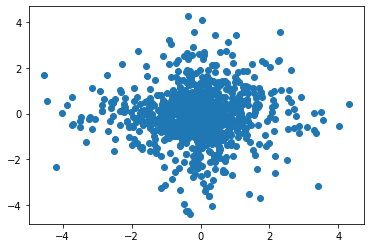

In [177]:
ITE_est_temp = torch.flatten(y_treat-y_hat_main,start_dim=0,end_dim=1).squeeze()
treatment_effect_temp = torch.flatten(treatment_effect,start_dim=0,end_dim=1).squeeze()

plt.scatter(treatment_effect_temp.detach().cpu().numpy(),(ITE_est_temp).detach().cpu().numpy())

In [ ]:
#0.4461 sd: 0.0367

#0.4422 sd: 0.03613